In [1]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle # Load refs and annotations
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration 

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO


import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np


import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import json

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw


/home/matea/Documents/VisualGrounding/DeepLearning/DeepBlasphemy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [2]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [5]:
print(annotations)

{89: [245.54, 208.17, 40.14, 19.1], 126: [117.47, 195.78, 128.51, 154.62], 207: [57.6, 87.65, 266.4, 195.12], 237: [217.74, 62.98, 45.66, 19.32], 239: [337.92, 149.5, 281.28, 188.16], 250: [94.08, 102.72, 545.92, 343.68], 284: [243.51, 210.5, 279.52, 186.92], 303: [314.64, 248.34, 114.47, 37.41], 353: [189.68, 401.24, 99.2, 54.27], 384: [119.73, 247.53, 162.7, 125.14], 395: [120.34, 332.05, 76.07, 86.53], 403: [199.39, 233.77, 84.95, 43.58], 433: [83.8, 126.17, 290.35, 101.42], 537: [499.87, 256.35, 65.08, 135.07], 555: [214.3, 349.09, 37.82, 12.61], 560: [109.82, 118.55, 274.91, 81.45], 562: [58.72, 130.82, 223.53, 75.2], 566: [17.81, 2.09, 608.4, 393.73], 595: [64.26, 191.23, 330.58, 66.58], 610: [1.03, 160.44, 636.23, 138.76], 633: [282.02, 72.19, 231.11, 230.3], 656: [325.16, 322.92, 225.03, 150.71], 662: [183.33, 268.8, 23.19, 122.23], 678: [63.08, 248.76, 90.5, 111.53], 690: [156.57, 491.83, 123.6, 92.02], 695: [297.98, 114.42, 38.59, 20.72], 747: [174.98, 188.83, 384.6, 110.02],

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
---------------------------------------------------
(tensor([[[[0.3725, 0.3412, 0.3922,  ..., 0.0510, 0.0471, 0.0471],
          [0.3882, 0.3490, 0.3765,  ..., 0.0431, 0.0392, 0.0353],
          [0.3686, 0.4078, 0.3922,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3686, 0.3373, 0.3882,  ..., 0.0510, 0.0471, 0.0471],
          [0.3843, 0.3451, 0.3804,  ..., 0.0431, 0.0392, 0.0353],
          [0.3725, 0.4118, 0.3961,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

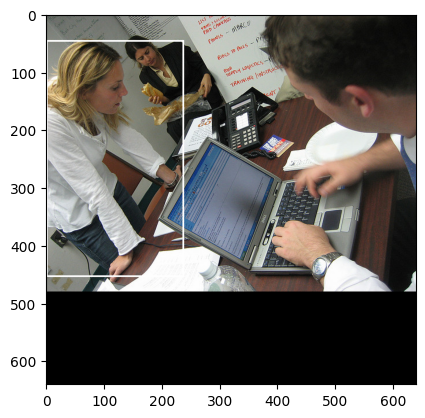

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0)

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
print(dataset[0])
print("---------------------------------------------------")
#plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:
"""
for d in dataloader:
    print(d)
    img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
    bbox = d[1]["bbox"][0]
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

    plt.imshow(img)
    plt.show()
    break
"""